In [1]:
#meta 10/30/2020 myCopy Ch.7 Working with Text Data
#book Introduction to ML with Python
#Andreas Muller

#task: Sentiment Analysis of Movie Reviews - with a classifier
#task: Topic Modeling in Movie Reviews
#input: reviews.csv

#install reqs in env: employee-survey-nlp
#conda install -c conda-forge spacy
#conda install -c conda-forge spacy-model-en_core_web_sm

#$note: Focus on code examples and not on model results 
#$mychange

#$mySummary: 
#Ex 1. Sentiment analysis
#a good start with a sklearn.LogisticRegession classifier to validate sentiment
#binary classifier {0,1} and extract pos and neg tokens
#Ex 2. Topic modeling
#a good start with LDA and 10 topics

#history
#10/30/2020 ALIGN CATEGORIES AND COLORS
#      Change y categories, 0=rotten, 1=fresh
#      Align with colors red ='rotten' and green='fresh'

In [2]:
%matplotlib inline
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#modeling help
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

#modeling imports inline

Global vars and functions

In [4]:
#copied form mglearn

#from mglearn.plot_helpers
from matplotlib.colors import ListedColormap 
#$mychange was blue '#0000aa' and red -> green '#00FF00' and red to match green='fresh' and red ='rotten'
cm = ListedColormap(['#00ff00', '#ff2020'])

#from mglearn.tools
def my_visualize_coefficients(coefficients, feature_names, n_top_features=25):
    """Visualize coefficients of a linear model.

    Parameters
    ----------
    coefficients : nd-array, shape (n_features,)
        Model coefficients.

    feature_names : list or nd-array of strings, shape (n_features,)
        Feature names for labeling the coefficients.

    n_top_features : int, default=25
        How many features to show. The function will show the largest (most
        positive) and smallest (most negative)  n_top_features coefficients,
        for a total of 2 * n_top_features coefficients.
    """
    coefficients = coefficients.squeeze()
    if coefficients.ndim > 1:
        # this is not a row or column vector
        raise ValueError("coeffients must be 1d array or column vector, got"
                         " shape {}".format(coefficients.shape))
    coefficients = coefficients.ravel()

    if len(coefficients) != len(feature_names):
        raise ValueError("Number of coefficients {} doesn't match number of"
                         "feature names {}.".format(len(coefficients),
                                                    len(feature_names)))
    # get coefficients with large absolute values
    coef = coefficients.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients,
                                          positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = [cm(1) if c < 0 else cm(0)
              for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients],
            color=colors)
    feature_names = np.array(feature_names)
    plt.subplots_adjust(bottom=0.3)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features),
               feature_names[interesting_coefficients], rotation=60,
               ha="right")
    plt.ylabel("Coefficient magnitude")
    plt.xlabel("Feature")

In [5]:
def my_heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f"):
    if ax is None:
        ax = plt.gca()
    # plot the mean cross-validation scores
    img = ax.pcolor(values, cmap=cmap, vmin=vmin, vmax=vmax)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)

    for p, color, value in zip(img.get_paths(), img.get_facecolors(),
                               img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt % value, color=c, ha="center", va="center")
    return img


In [6]:
def my_print_topics(topics, feature_names, sorting, topics_per_chunk=6,
                 n_words=20):
    for i in range(0, len(topics), topics_per_chunk):
        # for each chunk:
        these_topics = topics[i: i + topics_per_chunk]
        # maybe we have less than topics_per_chunk left
        len_this_chunk = len(these_topics)
        # print topic headers
        print(("topic {:<8}" * len_this_chunk).format(*these_topics))
        print(("-------- {0:<5}" * len_this_chunk).format(""))
        # print top n_words frequent words
        for i in range(n_words):
            try:
                print(("{:<14}" * len_this_chunk).format(
                    *feature_names[sorting[these_topics, i]]))
            except:
                pass
        print("\n")

# Working with Text Data
myCopy with pre-formatted reviews.csv file

## 0. myLoad Data
input: reviews.csv  
Already transformed into .csv format

Dig into the data a bit do see what you're dealing with.  Begin by loading the datasets and dropping rows that have missing data

In [7]:
#movies_orig = pd.read_csv("../myData/movies.dat", delimiter='\t')
#reviews_orig = pd.read_csv('../myData/reviews.csv')
reviews_orig = pd.read_csv('myData/reviews.csv')

# drop rows that have missing data
reviews=reviews_orig.copy()
reviews = reviews[~reviews.quote.isnull()] 
reviews = reviews[reviews.fresh != 'none'] #reduced dataset
reviews = reviews[reviews.quote.str.len() > 0]

reviews_orig.shape, reviews.shape

((13442, 9), (13419, 9))

In [8]:
#preview
reviews.tail()

,critic,fresh,imdb,link,publication,quote,review_date,rtid,title
13437,Gene Siskel,rotten,88683,http://articles.chicagotribune.com/1985-09-13/...,Chicago Tribune,Agnes of God plays with some challenging ideas...,2013-05-08 00:00:00,11917,Agnes of God
13438,Variety Staff,rotten,88683,http://www.variety.com/review/VE1117796703.htm...,Variety,"Fonda's relentless interrogating, mannered cha...",2008-10-18 00:00:00,11917,Agnes of God
13439,NaN,fresh,88683,http://www.timeout.com/film/reviews/77605/agne...,Time Out,Splendidly shot by Sven Nykvist and with excel...,2006-06-24 00:00:00,11917,Agnes of God
13440,Janet Maslin,rotten,88683,http://movies.nytimes.com/movie/review?res=950...,New York Times,"Miss Tilly makes a radiant Agnes, and Miss Ban...",2003-05-20 00:00:00,11917,Agnes of God
13441,Roger Ebert,rotten,88683,http://www.rogerebert.com/reviews/agnes-of-god...,Chicago Sun-Times,Although the movie deals in the basic material...,2000-01-01 00:00:00,11917,Agnes of God


## 1. Prep Data

Tidy data

In [9]:
reviews_tidy = reviews[['quote', 'fresh']].copy()
reviews_tidy = reviews_tidy.assign(category = lambda x: (x['fresh']=='fresh'))

print(reviews_tidy.shape)
reviews_tidy.dtypes

(13419, 3)


quote       object
fresh       object
category      bool
dtype: object

X and y

In [10]:
#interested in words in all rows, column 0
#this text_train
X = reviews_tidy.iloc[:,0]
X.shape

(13419,)

In [11]:
#for supervised learning
y = reviews_tidy['category'].astype(int)
print(y.shape)
y

(13419,)


0        1
1        1
2        1
3        1
4        1
        ..
13437    0
13438    0
13439    1
13440    0
13441    0
Name: category, Length: 13419, dtype: int32

In [12]:
print("Samples per class: {}".format(np.bincount(y)))

Samples per class: [5030 8389]


Split X&y into train and test datasets for supervised learning

In [13]:
# Randomly split data into two groups: a training set and a validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state=24)

#done - print summary 
print ("\nTotal records in learning set: {}".format(reviews_tidy.shape[0]))
print ("Total records in training set: {}".format(len(X_train)))
print ("Total records in test set: {}".format(len(X_test)))
    
#notice index after reshuffling
X_train.tail()


Total records in learning set: 13419
Total records in training set: 10735
Total records in test set: 2684


10400    There's nothing more static than a stalled fri...
3480     Film is so formulaic that virtually every plot...
8549     An extended collection of one-liners and not m...
903      Waller's witty, well-crafted yet unpretentious...
12728    [The film brings] horror home to a place where...
Name: quote, dtype: object

In [14]:
print("Samples per class, trainset: {}".format(np.bincount(y_train)))
print("Samples per class, testset: {}".format(np.bincount(y_test)))

Samples per class, trainset: [4017 6718]
Samples per class, testset: [1013 1671]


## 2. Modeling

### 2.1 Example application: Sentiment analysis of movie reviews


##### Bag-of-word for movie reviews
Representing text data as Bag of Words

<img alt="Diagram bag-of-words" width="450" src="images/bag_of_words.png">

In [15]:
#$note: just to fit into this notebook
text_train = X_train
text_test = X_test

In [16]:
vect = CountVectorizer().fit(text_train)
X_train = vect.transform(text_train)
print("X_train:\n{}".format(repr(X_train)))

X_train:
<10735x18981 sparse matrix of type '<class 'numpy.int64'>'
	with 194199 stored elements in Compressed Sparse Row format>


In [17]:
feature_names = vect.get_feature_names()
print("Number of features: {}".format(len(feature_names)))
print("First 20 features:\n{}".format(feature_names[:20]))
print("Features 20010 to 20030:\n{}".format(feature_names[20010:20030]))
print("Every 2000th feature:\n{}".format(feature_names[::2000]))

Number of features: 18981
First 20 features:
['000', '0014', '007', '044', '10', '100', '101', '104', '105', '108', '10th', '11', '110', '112', '114', '118', '11th', '12', '124', '125']
Features 20010 to 20030:
[]
Every 2000th feature:
['000', 'boringly', 'curbing', 'facet', 'hoarse', 'lumbering', 'paralysis', 'revolutions', 'sternest', 'ushered']


In [18]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
scores = cross_val_score(LogisticRegression(max_iter=1000), X_train, y_train, cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))

Mean cross-validation accuracy: 0.77


In [19]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best cross-validation score: 0.77
Best parameters:  {'C': 1}


In [20]:
X_test = vect.transform(text_test)
print("Test score: {:.2f}".format(grid.score(X_test, y_test)))

Test score: 0.76


In [21]:
vect = CountVectorizer(min_df=5).fit(text_train)
X_train = vect.transform(text_train)
print("X_train with min_df: {}".format(repr(X_train)))

X_train with min_df: <10735x4775 sparse matrix of type '<class 'numpy.int64'>'
	with 170344 stored elements in Compressed Sparse Row format>


In [22]:
feature_names = vect.get_feature_names()

print("First 50 features:\n{}".format(feature_names[:50]))
print("Features 20010 to 20030:\n{}".format(feature_names[20010:20030]))
print("Every 700th feature:\n{}".format(feature_names[::700]))

First 50 features:
['007', '10', '100', '11', '12', '13', '13th', '15', '1930s', '1933', '1939', '1940s', '1950s', '1960s', '1961', '1963', '1964', '1968', '1970s', '1976', '1979', '1985', '1993', '1995', '1998', '20', '2001', '2008', '20th', '21st', '30', '30s', '40', '45', '50', '50s', '60s', '70s', '80', '80s', '85', '90', '90s', 'ability', 'able', 'ably', 'abound', 'about', 'above', 'absence']
Features 20010 to 20030:
[]
Every 700th feature:
['007', 'characteristic', 'escape', 'ill', 'mush', 'ridiculous', 'tedious']


In [23]:
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

Best cross-validation score: 0.76


##### BOW with Stop-words

In [24]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
print("Number of stop words: {}".format(len(ENGLISH_STOP_WORDS)))
print("Every 10th stopword:\n{}".format(list(ENGLISH_STOP_WORDS)[::10]))

Number of stop words: 318
Every 10th stopword:
['thereby', 'hundred', 'thru', 'eleven', 'within', 'is', 'down', 'third', 'cannot', 'alone', 'beside', 'because', 'therefore', 'found', 'him', 'once', 'ever', 'twenty', 'has', 'always', 'detail', 'yourselves', 'to', 'many', 'amoungst', 'few', 'put', 'name', 'well', 'eight', 'against', 'everywhere']


In [25]:
# Specifying stop_words="english" uses the built-in list.
# We could also augment it and pass our own.
vect = CountVectorizer(min_df=5, stop_words="english").fit(text_train)
X_train = vect.transform(text_train)
print("X_train with stop words:\n{}".format(repr(X_train)))

X_train with stop words:
<10735x4516 sparse matrix of type '<class 'numpy.int64'>'
	with 87921 stored elements in Compressed Sparse Row format>


In [26]:
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

Best cross-validation score: 0.75


##### BOW Rescaling the Data with tf-idf
\begin{equation*}
\text{tfidf}(w, d) = \text{tf} \log\big(\frac{N + 1}{N_w + 1}\big) + 1
\end{equation*}

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(TfidfVectorizer(min_df=5, norm=None),
                     LogisticRegression(max_iter=1000))
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(text_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

Best cross-validation score: 0.76


In [28]:
vectorizer = grid.best_estimator_.named_steps["tfidfvectorizer"]
# transform the training dataset:
X_train = vectorizer.transform(text_train)
# find maximum value for each of the features over dataset:
max_value = X_train.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()
# get feature names
feature_names = np.array(vectorizer.get_feature_names())

print("Features with lowest tfidf:\n{}".format(
      feature_names[sorted_by_tfidf[:20]]))

print("Features with highest tfidf: \n{}".format(
      feature_names[sorted_by_tfidf[-20:]]))

Features with lowest tfidf:
['here' 'plot' 'while' 'also' 'character' 'performances' 'script'
 'audience' 'end' 'cast' 'entertainment' 'yet' 'actors' 'before'
 'dialogue' 'tale' 'genre' 'heart' 'set' 'piece']
Features with highest tfidf: 
['you' 'sequels' 'incredibly' 'part' 'bloody' 'was' 'cry' 'friday' 'upper'
 'major' '13th' 'kitsch' 'liar' 'jude' 'her' 'case' 'extremely' 'as'
 'bond' 'hated']


In [29]:
sorted_by_idf = np.argsort(vectorizer.idf_)
print("Features with lowest idf:\n{}".format(
       feature_names[sorted_by_idf[:100]]))

Features with lowest idf:
['the' 'and' 'of' 'is' 'to' 'it' 'in' 'that' 'but' 'with' 'film' 'this'
 'as' 'movie' 'for' 'an' 'its' 'be' 'on' 'has' 'by' 'not' 'one' 'are'
 'more' 'all' 'you' 'his' 'than' 'at' 'from' 'about' 'have' 'most' 'like'
 'so' 'there' 'or' 'story' 'what' 'good' 'if' 'can' 'into' 'who' 'up' 'he'
 'much' 'time' 'out' 'best' 'comedy' 'even' 'director' 'which' 'too'
 'just' 'well' 'some' 'no' 'only' 'movies' 'they' 'their' 'characters'
 'funny' 'picture' 'first' 'make' 'action' 'way' 'may' 'when' 'made'
 'been' 'will' 'was' 'little' 'makes' 'work' 'great' 'very' 'never' 'we'
 'enough' 'films' 'doesn' 'here' 'new' 'any' 'us' 'does' 'still'
 'thriller' 'though' 'two' 'plot' 'them' 'fun' 'through']


#### 2.1.a Vis: Investigating model coefficients

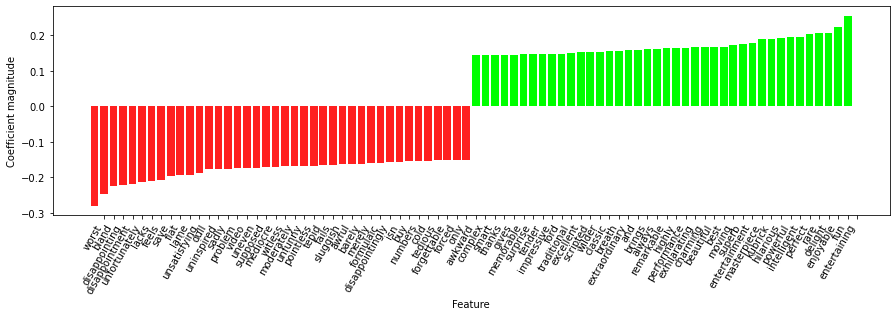

In [30]:
my_visualize_coefficients(
    grid.best_estimator_.named_steps["logisticregression"].coef_,
    feature_names, n_top_features=40)

##### BOW with more n-grams

In [31]:
pipe = make_pipeline(TfidfVectorizer(min_df=5), LogisticRegression(max_iter=1000))
# running the grid-search takes a long time because of the
# relatively large grid and the inclusion of trigrams
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
              "tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)]}

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(text_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

Best cross-validation score: 0.77
Best parameters:
{'logisticregression__C': 10, 'tfidfvectorizer__ngram_range': (1, 3)}


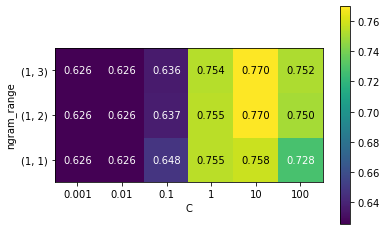

In [32]:
# extract scores from grid_search
scores = grid.cv_results_['mean_test_score'].reshape(-1, 3).T
# visualize heat map
heatmap = my_heatmap(
    scores, xlabel="C", ylabel="ngram_range", cmap="viridis", fmt="%.3f",
    xticklabels=param_grid['logisticregression__C'],
    yticklabels=param_grid['tfidfvectorizer__ngram_range'])
plt.colorbar(heatmap)

#### 2.1.b Vis: Investigating model coefficients with n-grams

(-22.0, 22.0)

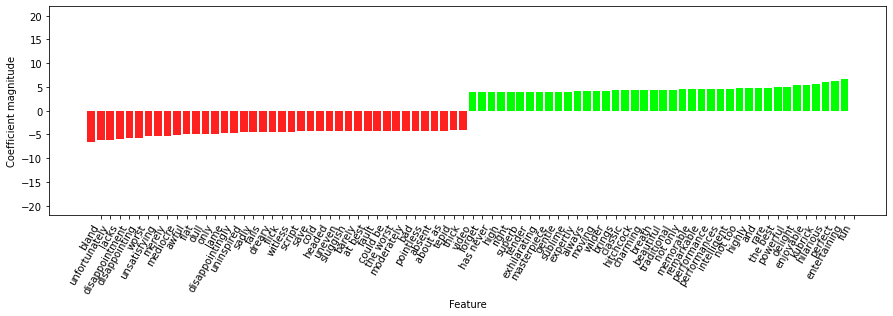

In [33]:
# extract feature names and coefficients
vect = grid.best_estimator_.named_steps['tfidfvectorizer']
feature_names = np.array(vect.get_feature_names())
coef = grid.best_estimator_.named_steps['logisticregression'].coef_
my_visualize_coefficients(coef, feature_names, n_top_features=40)
plt.ylim(-22, 22)

(-22.0, 22.0)

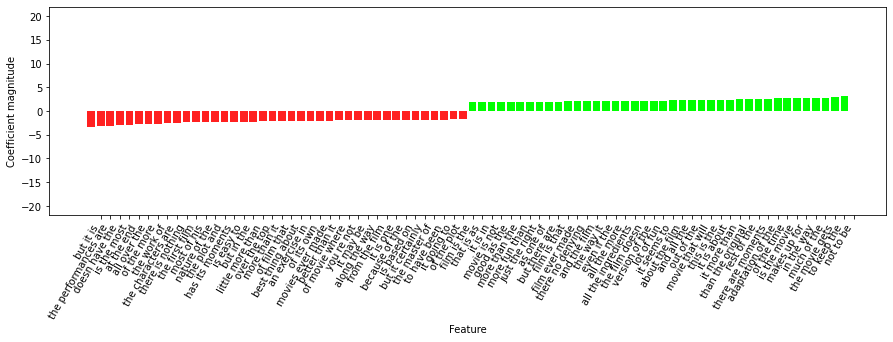

In [34]:
# find 3-gram features
mask = np.array([len(feature.split(" ")) for feature in feature_names]) == 3
# visualize only 3-gram features
my_visualize_coefficients(coef.ravel()[mask],
                                     feature_names[mask], n_top_features=40)
plt.ylim(-22, 22)

#### 2.1.2 Advanced tokenization, stemming and lemmatization

In [35]:
import spacy
import nltk

# load spacy's English-language models
en_nlp = spacy.load("en_core_web_sm")
# instantiate nltk's Porter stemmer
stemmer = nltk.stem.PorterStemmer()

# define function to compare lemmatization in spacy with stemming in nltk
def compare_normalization(doc):
    # tokenize document in spacy
    doc_spacy = en_nlp(doc)
    # print lemmas found by spacy
    print("Lemmatization:")
    print([token.lemma_ for token in doc_spacy])
    # print tokens found by Porter stemmer
    print("Stemming:")
    print([stemmer.stem(token.norm_.lower()) for token in doc_spacy])

In [36]:
compare_normalization(u"Our meeting today was worse than yesterday, "
                       "I'm scared of meeting the clients tomorrow.")

Lemmatization:
['-PRON-', 'meeting', 'today', 'be', 'bad', 'than', 'yesterday', ',', '-PRON-', 'be', 'scared', 'of', 'meet', 'the', 'client', 'tomorrow', '.']
Stemming:
['our', 'meet', 'today', 'wa', 'wors', 'than', 'yesterday', ',', 'i', 'am', 'scare', 'of', 'meet', 'the', 'client', 'tomorrow', '.']


In [37]:
# Technicallity: we want to use the regexp based tokenizer
# that is used by CountVectorizer  and only use the lemmatization
# from SpaCy. To this end, we replace en_nlp.tokenizer (the SpaCy tokenizer)
# with the regexp based tokenization
import re
# regexp used in CountVectorizer:
regexp = re.compile('(?u)\\b\\w\\w+\\b')
# load spacy language model
en_nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
old_tokenizer = en_nlp.tokenizer
# replace the tokenizer with the preceding regexp
en_nlp.tokenizer = lambda string: old_tokenizer.tokens_from_list(
    regexp.findall(string))

# create a custom tokenizer using the SpaCy document processing pipeline
# (now using our own tokenizer)
def custom_tokenizer(document):
    doc_spacy = en_nlp(document)
    return [token.lemma_ for token in doc_spacy]

# define a count vectorizer with the custom tokenizer
lemma_vect = CountVectorizer(tokenizer=custom_tokenizer, min_df=5)

In [38]:
# transform text_train using CountVectorizer with lemmatization
X_train_lemma = lemma_vect.fit_transform(text_train)
print("X_train_lemma.shape: {}".format(X_train_lemma.shape))

# standard CountVectorizer for reference
vect = CountVectorizer(min_df=5).fit(text_train)
X_train = vect.transform(text_train)
print("X_train.shape: {}".format(X_train.shape))

D:\Anaconda3\envs\employee-survey-nlp\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: [W002] Tokenizer.from_list is now deprecated. Create a new Doc object instead and pass in the strings as the `words` keyword argument, for example:
from spacy.tokens import Doc
doc = Doc(nlp.vocab, words=[...])
  del sys.path[0]


X_train_lemma.shape: (10735, 4327)
X_train.shape: (10735, 4775)


In [39]:
# build a grid-search using only 1% of the data as training set:
from sklearn.model_selection import StratifiedShuffleSplit

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.99,
                            train_size=0.01, random_state=0)
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=cv)
# perform grid search with standard CountVectorizer
grid.fit(X_train, y_train)
print("Best cross-validation score "
      "(standard CountVectorizer): {:.3f}".format(grid.best_score_))
# perform grid search with Lemmatization
grid.fit(X_train_lemma, y_train)
print("Best cross-validation score "
      "(lemmatization): {:.3f}".format(grid.best_score_))

Best cross-validation score (standard CountVectorizer): 0.626
Best cross-validation score (lemmatization): 0.626


### 2.2 Example application: Topic Modeling and Document Clustering
##### Latent Dirichlet Allocation

In [40]:
vect = CountVectorizer(max_features=10000, max_df=.15)
X = vect.fit_transform(text_train)

In [41]:
#$mychange was n_topics -> n_components
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=10, learning_method="batch",
                                max_iter=25, random_state=0)
# We build the model and transform the data in one step
# Computing transform takes some time,
# and we can save time by doing both at once
document_topics = lda.fit_transform(X)

In [42]:
print("lda.components_.shape: {}".format(lda.components_.shape))

lda.components_.shape: (10, 10000)


In [43]:
# for each topic (a row in the components_), sort the features (ascending).
# Invert rows with [:, ::-1] to make sorting descending
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
# get the feature names from the vectorizer:
feature_names = np.array(vect.get_feature_names())

In [44]:
# Print out the 10 topics:
my_print_topics(topics=range(10), feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=5, n_words=10)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
you           for           one           as            than          
movie         this          film          for           more          
this          its           are           its           this          
be            on            its           an            be            
for           movie         most          are           film          
if            by            movie         this          an            
have          not           what          comic         good          
will          from          by            more          better        
not           film          made          film          as            
by            disney        ever          than          for           


topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------      --------      
an  

In [45]:
mystop
#code below breaks
#ok to move on, if fix needed look into misaligned indices

NameError: name 'mystop' is not defined

In [ ]:
lda20 = LatentDirichletAllocation(n_components=20, learning_method="batch",
                                   max_iter=25, random_state=0)
document_topics20 = lda20.fit_transform(X)

In [ ]:
topics = np.array([2, 3, 5, 7, 11, 13, 17, 19])

In [ ]:
sorting = np.argsort(lda20.components_, axis=1)[:, ::-1]
feature_names = np.array(vect.get_feature_names())
my_print_topics(topics=topics, feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=5, n_words=20)

In [ ]:
for idx in music[:10]:
    print (idx in text_train.index)

In [ ]:
# sort by weight of "music" topic 45
music = np.argsort(document_topics20[:, 17])[::-1]
# print the five documents where the topic is most important
for i in music[:10]:
    # show first two sentences
    print(".".join(text_train[i].split(".")[:2]) + ".\n")

In [ ]:
# sort by weight of "music" topic 45
music = np.argsort(document_topics20[:, 45])[::-1]
# print the five documents where the topic is most important
for i in music[:10]:
    # show first two sentences
    print(b".".join(text_train[i].split(b".")[:2]) + b".\n")

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
topic_names = ["{:>2} ".format(i) + " ".join(words)
               for i, words in enumerate(feature_names[sorting[:, :2]])]
# two column bar chart:
for col in [0, 1]:
    start = col * 50
    end = (col + 1) * 50
    ax[col].barh(np.arange(50), np.sum(document_topics100, axis=0)[start:end])
    ax[col].set_yticks(np.arange(50))
    ax[col].set_yticklabels(topic_names[start:end], ha="left", va="top")
    ax[col].invert_yaxis()
    ax[col].set_xlim(0, 2000)
    yax = ax[col].get_yaxis()
    yax.set_tick_params(pad=130)
plt.tight_layout()

### Summary and Outlook